#  **In this project , I demonstrate how to estimate the head pose from a single image using MediaPipe FaceMesh and OpenCV**

## Install mediapipe

In [2]:
%%capture
!pip install mediapipe


# **Required Libraries**

In [3]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow

## **Read Data**

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
# from zipfile import ZipFile
# with ZipFile('drive/MyDrive/ML_project/AFLW2000-3D (1).zip') as zipObj:
#   zipObj.extractall("drive/MyDrive/ML_project/AFLW2000-3D")

In [6]:

import os

directory = 'drive/MyDrive/ML_project/AFLW2000-3D/AFLW2000'

all_files = [os.path.join(directory, f) for f in os.listdir(directory)]

# Separate JPG and MAT files
jpg_files1 = [file_path for file_path in all_files if file_path.endswith('.jpg')]
mat_files1 = [file_path for file_path in all_files if file_path.endswith('.mat')]

# Sort files based on names
jpg_files = sorted(jpg_files1)
mat_files = sorted(mat_files1)

# Now, you have sorted lists of JPG and MAT files


In [7]:
jpg_files[0]


'drive/MyDrive/ML_project/AFLW2000-3D/AFLW2000/image00002.jpg'

In [8]:

mat_files[0]

'drive/MyDrive/ML_project/AFLW2000-3D/AFLW2000/image00002.mat'

## Draw Axis


In [9]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),3)

    return img

# Explore Dataset

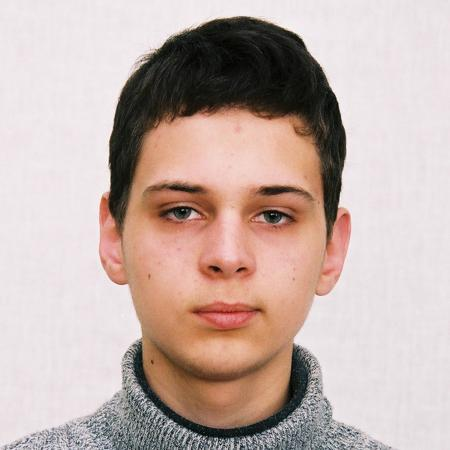

In [65]:
image = cv2.imread(jpg_files[40])
cv2_imshow(image)

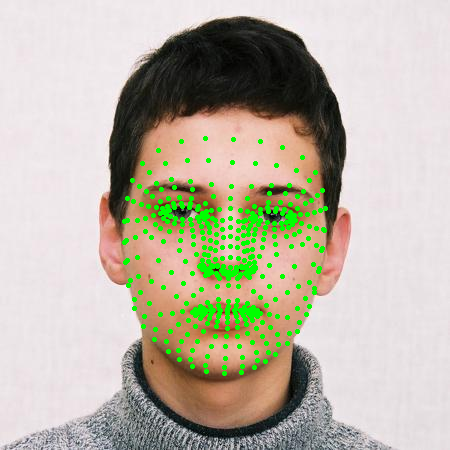

In [57]:
faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None:
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          shape = image.shape
          nose_x = int(face.landmark[4].x * shape[1])
          nose_y = int(face.landmark[4].y * shape[0])
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
      cv2_imshow(image)

In [60]:
faceModule = mediapipe.solutions.face_mesh
face=faceModule.FaceMesh(static_image_mode=True)
res=face.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
for face in res.multi_face_landmarks:
      print(face.landmark[0])
      print("*"*100)


      x = face.landmark[4].x
      y = face.landmark[4].y
      print(x)
      print(y)


x: 0.5088835954666138
y: 0.6676716804504395
z: -0.05575542896986008

****************************************************************************************************
0.5139455199241638
0.5715807676315308


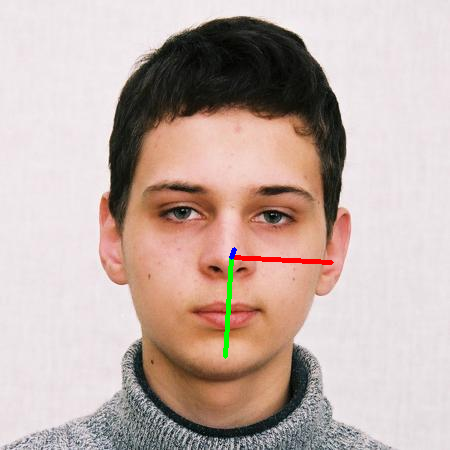

In [61]:
image = cv2.imread(jpg_files[40])
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat(mat_files[40])
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
img_h, img_w, img_c = image.shape
tdy=y * img_h
tdx=x * img_w
cv2_imshow(draw_axis(image,pitch,yaw,roll,tdx,tdy))

# Feature Extraction from Data

In [14]:
import mediapipe
import cv2
import os
import numpy as np
import scipy.io as sio

# Load the FaceMesh module
faceModule = mediapipe.solutions.face_mesh

# Create FaceMesh instance
features = []

# for image_path, mat_file_path in zip(jpg_files, mat_files):
for i in range(len(jpg_files)):
    image_features = []
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        # Read image
        img = cv2.imread(jpg_files[i])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Process the image with FaceMesh
        results = faces.process(img_rgb)

        if results.multi_face_landmarks:
            # Assuming there's only one face in the image
            nose_landmark = results.multi_face_landmarks[0].landmark[4]
            chin_landmark = results.multi_face_landmarks[0].landmark[152]
            Distance = np.sqrt((nose_landmark.x - chin_landmark.x)**2 + (nose_landmark.y - chin_landmark.y)**2)
            for face in results.multi_face_landmarks:
                for landmark in face.landmark:
                    x = (landmark.x-nose_landmark.x )/ Distance
                    y = (landmark.y -nose_landmark.y) / Distance

                    image_features.extend([x, y])

            # Read pose angles from the corresponding MAT file
            mat_data = sio.loadmat(mat_files[i])
            pose_angles = mat_data['Pose_Para'][0][:3]
            image_features.extend(pose_angles)

            features.append(image_features)
        else:
            # Handle the case where no face is detected
            features.append([None] * 936)  # Assuming 468 landmarks (x, y) + 3 pose angles

# Now, the 'features' list contains the extracted features for each image
# You can convert it into a DataFrame or use it as needed.


# Data Preprocessing:

In [15]:
len(features)

2000

In [16]:
df = pd.DataFrame(features)
df

,0,1,2,3,4,5,6,7,8,9,...,929,930,931,932,933,934,935,936,937,938
0,-0.023766,0.318033,-0.006607,0.089623,-0.003661,0.126111,-0.052436,-0.284171,0.0,0.0,...,-0.621764,0.246334,-0.585163,0.847951,-0.725764,0.898419,-0.761263,-0.399231,0.018227,0.085676
1,0.135390,0.342489,0.007973,0.080386,0.173977,0.176596,0.106425,-0.167740,0.0,0.0,...,-0.343096,0.446485,-0.326326,0.887145,-0.403468,0.937679,-0.429012,0.470065,1.189533,0.300959
2,-0.034451,0.295173,-0.001236,0.081678,-0.029573,0.134064,-0.097803,-0.205510,0.0,0.0,...,-0.441704,0.067555,-0.418426,0.488717,-0.515062,0.528595,-0.545855,-0.184650,0.881137,-0.236852
3,0.206938,0.278244,0.038110,0.079997,0.136178,0.103737,-0.085015,-0.232270,0.0,0.0,...,-0.623308,0.141488,-0.583820,0.656938,-0.893207,0.691559,-0.947129,-0.175379,0.299208,-0.373374
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-0.056898,0.364123,-0.013462,0.097607,-0.029582,0.156435,-0.064382,-0.279807,0.0,0.0,...,-0.582368,0.225926,-0.553400,0.822239,-0.653323,0.873485,-0.689914,-0.197102,-0.070430,0.105118
1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
columns = []

# Extend the columns with X and Y
for i in range(1, 469):
    columns.extend([f'X{i}', f'Y{i}'])

# Add the pose angle columns
columns += ['Pitch', 'Yaw', 'Roll']

# Create the DataFrame
df = pd.DataFrame(features, columns=columns)


In [18]:
df.head(3)

,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,...,Y465,X466,Y466,X467,Y467,X468,Y468,Pitch,Yaw,Roll
0,-0.023766,0.318033,-0.006607,0.089623,-0.003661,0.126111,-0.052436,-0.284171,0.0,0.0,...,-0.621764,0.246334,-0.585163,0.847951,-0.725764,0.898419,-0.761263,-0.399231,0.018227,0.085676
1,0.135390,0.342489,0.007973,0.080386,0.173977,0.176596,0.106425,-0.167740,0.0,0.0,...,-0.343096,0.446485,-0.326326,0.887145,-0.403468,0.937679,-0.429012,0.470065,1.189533,0.300959
2,-0.034451,0.295173,-0.001236,0.081678,-0.029573,0.134064,-0.097803,-0.205510,0.0,0.0,...,-0.441704,0.067555,-0.418426,0.488717,-0.515062,0.528595,-0.545855,-0.184650,0.881137,-0.236852


In [19]:
data=df.dropna()
data.shape

(1853, 939)

In [20]:

data.to_csv('./Head_poses.csv', index=False)

In [20]:
#data=pd.read_csv("/content/poses_WH_column.csv")

## Spliting Data:

In [21]:
features = data.drop(['Pitch'	,'Yaw','Roll'], axis=1)
labels = data[['Pitch'	,'Yaw','Roll']]

In [22]:
from sklearn.model_selection import train_test_split
features_train, features_validation_test, labels_train, labels_validation_test = train_test_split(
    features, labels, test_size=0.2, random_state=100)

features_validation, features_test, labels_validation, labels_test = train_test_split(
    features_validation_test, labels_validation_test, test_size=0.5, random_state=100)
print(features_train.shape, labels_train.shape)

(1482, 936) (1482, 3)


In [23]:
print("features_train :",len(features_train))
print("features_validation :",len(features_validation))
print("features_test :",len(features_test))
print("labels_train :",len(labels_train))
print("labels_validation :",len(labels_validation))
print("labels_test :",len(labels_test))

features_train : 1482
features_validation : 185
features_test : 186
labels_train : 1482
labels_validation : 185
labels_test : 186


# Model Training:

We'll train five models:
- Decision tree Regressor
- Support vector machine (SVR)
- RandomForestRegressor
- GradientBoostingRegressorr
- AdaBoostRegressor
|

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [29]:
rf_model_Pitch =RandomForestRegressor()
rf_model_Yaw =RandomForestRegressor()
rf_model_Roll =RandomForestRegressor()
gb_model_Pitch =GradientBoostingRegressor()
gb_model_Yaw =GradientBoostingRegressor()
gb_model_Roll =GradientBoostingRegressor()
ab_model_Pitch =AdaBoostRegressor()
ab_model_Yaw=AdaBoostRegressor()
ab_model_Roll =AdaBoostRegressor()
dt_model_Pitch =DecisionTreeRegressor()
dt_model_Yaw =DecisionTreeRegressor()
dt_model_Roll=DecisionTreeRegressor()
svr_model_Pitch = SVR()
svr_model_Yaw = SVR()
svr_model_Roll = SVR()

In [26]:
from sklearn.metrics import f1_score
def fit_model(model_Pitch,model_Yaw,model_Roll,features_train=features_train,labels_train=labels_train,features_validation=features_validation,labels_validation=labels_validation):
    # Train the models
      model_Pitch.fit(features_train, labels_train['Pitch'])
      model_Yaw.fit(features_train, labels_train['Yaw'])
      model_Roll.fit(features_train, labels_train['Roll'])

      # Evaluate the models
      score_Pitch= model_Pitch.score(features_validation, labels_validation['Pitch'])
      score_Yaw = model_Yaw.score(features_validation, labels_validation['Yaw'])
      score_Roll= model_Roll.score(features_validation, labels_validation['Roll'])

      print("R^2 score for Pitch:", score_Pitch)
      print("R^2 score for Yaw:", score_Yaw)
      print("R^2 score for Roll:", score_Roll)
          # Make predictions on validation set for MSE computation
      predictions_Pitch = model_Pitch.predict(features_validation)
      predictions_Yaw = model_Yaw.predict(features_validation)
      predictions_Roll = model_Roll.predict(features_validation)
      # Compute MSE for each label
      mse_Pitch = mean_squared_error(labels_validation['Pitch'], predictions_Pitch)
      mse_Yaw = mean_squared_error(labels_validation['Yaw'], predictions_Yaw)
      mse_Roll = mean_squared_error(labels_validation['Roll'], predictions_Roll)

      print("Mean Squared Error (MSE) for Pitch:", mse_Pitch)
      print("Mean Squared Error (MSE) for Yaw:", mse_Yaw)
      print("Mean Squared Error (MSE) for Roll:", mse_Roll)
      return  model_Pitch,model_Yaw,model_Roll

In [ ]:
print("RandomForestClassifier********************************************************")
rf_model_Pitch,rf_model_Yaw,rf_model_Roll=fit_model(rf_model_Pitch,rf_model_Yaw,rf_model_Roll,features_train, labels_train, features_validation, labels_validation)
print("GradientBoostingClassifier********************************************************")
gb_model_Pitch,gb_model_Yaw,gb_model_Roll=fit_model(gb_model_Pitch,gb_model_Yaw,gb_model_Roll,features_train, labels_train, features_validation, labels_validation)
print("AdaBoostClassifier********************************************************")
ab_model_Pitch,ab_model_Yaw,ab_model_Roll=fit_model(ab_model_Pitch,ab_model_Yaw,ab_model_Roll,features_train, labels_train, features_validation, labels_validation)
print("DecisionTreeClassifier********************************************************")
dt_model_Pitch,dt_model_Yaw,dt_model_Roll=fit_model(dt_model_Pitch,dt_model_Yaw,dt_model_Roll,features_train, labels_train, features_validation, labels_validation)
print("SVR********************************************************")
svr_model_Pitch,svr_model_Yaw,svr_model_Roll=fit_model(svr_model_Pitch,svr_model_Yaw,svr_model_Roll,features_train, labels_train, features_validation, labels_validation)

RandomForestClassifier********************************************************
R^2 score for 936: 0.6736408432147224
R^2 score for 937: 0.9656572435000625
R^2 score for 938: 0.825470537516206
GradientBoostingClassifier********************************************************
R^2 score for 936: 0.7226801118074937
R^2 score for 937: 0.9588252978177326
R^2 score for 938: 0.8451807050404351
AdaBoostClassifier********************************************************
R^2 score for 936: 0.009952592188469556
R^2 score for 937: 0.8416649729953852
R^2 score for 938: 0.33088999508473715
DecisionTreeClassifier********************************************************
R^2 score for 936: 0.5077699283817076
R^2 score for 937: 0.925149451621503
R^2 score for 938: 0.7229443079407613
SVR********************************************************
R^2 score for 936: 0.752227610893601
R^2 score for 937: 0.967390051048216
R^2 score for 938: 0.8346813670804643


### I will use SVR in prediction
#### try many hyperparameter by using Grid Search

In [30]:
print("SVR********************************************************")
svr_model_Pitch,svr_model_Yaw,svr_model_Roll=fit_model(svr_model_Pitch,svr_model_Yaw,svr_model_Roll,features_train, labels_train, features_validation, labels_validation)

SVR********************************************************
R^2 score for Pitch: 0.752227610893601
R^2 score for Yaw: 0.967390051048216
R^2 score for Roll: 0.8346813670804643
Mean Squared Error (MSE) for Pitch: 0.021977079749316213
Mean Squared Error (MSE) for Yaw: 0.010331327728442153
Mean Squared Error (MSE) for Roll: 0.016882458776741008


In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Define the SVR model with a pipeline including StandardScaler

svr_model_pitch = SVR()
svr_model_yaw = SVR()
svr_model_roll = SVR()
# Define the parameter grid for grid search
param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'gamma':[0.1,0.01,1]
}

# Create a GridSearchCV object
grid_search1 = GridSearchCV(svr_model_pitch, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search2 = GridSearchCV(svr_model_yaw, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search3 = GridSearchCV(svr_model_roll, param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the grid search to the data
grid_search1.fit(features_train, labels_train['Pitch'])  # Adjust the target variable
grid_search2.fit(features_train, labels_train['Yaw'])  # Adjust the target variable
grid_search3.fit(features_train, labels_train['Roll'])  # Adjust the target variable

# Print the best hyperparameters
print("Best hyperparameters:", grid_search1.best_params_)
print("Best hyperparameters:", grid_search2.best_params_)
print("Best hyperparameters:", grid_search3.best_params_)

# Get the best model from the grid search
best_svr_model1 = grid_search1.best_estimator_
best_svr_model2 = grid_search2.best_estimator_
best_svr_model3 = grid_search3.best_estimator_
print(best_svr_model1,best_svr_model2,best_svr_model3)





Best hyperparameters: {'C': 1, 'epsilon': 0.1, 'gamma': 0.01}
Best hyperparameters: {'C': 1, 'epsilon': 0.1, 'gamma': 0.01}
Best hyperparameters: {'C': 1, 'epsilon': 0.1, 'gamma': 0.01}
SVR(C=1, gamma=0.01) SVR(C=1, gamma=0.01) SVR(C=1, gamma=0.01)


In [47]:
# Create SVR instances with the best hyperparameters
best_svr_model_Pitch = SVR(C=10, gamma=0.01,epsilon=0.1)
best_svr_model_Yaw = SVR(C=10, gamma=0.01,epsilon=0.1)
best_svr_model_Roll = SVR(C=10, gamma=0.01,epsilon=0.1)
best_svr_model_Pitch,best_svr_model_Yaw,best_svr_model_Roll=fit_model(best_svr_model_Pitch,best_svr_model_Yaw,best_svr_model_Roll,features_train, labels_train, features_validation, labels_validation)


R^2 score for Pitch: 0.7747795856775118
R^2 score for Yaw: 0.9695087514398809
R^2 score for Roll: 0.8601179557125722
Mean Squared Error (MSE) for Pitch: 0.019976749728210657
Mean Squared Error (MSE) for Yaw: 0.009660091225219334
Mean Squared Error (MSE) for Roll: 0.014284855884564329


# Model Test

Test  Models of Best hyperparameters

In [48]:
score_Pitch = best_svr_model_Pitch.score(features_test, labels_test['Pitch'])
score_Yaw = best_svr_model_Yaw.score(features_test, labels_test['Yaw'])
score_Roll = best_svr_model_Roll.score(features_test, labels_test['Roll'])
print("R^2 score for Pitch:", score_Pitch)
print("R^2 score for Yaw:", score_Yaw)
print("R^2 score for Roll:", score_Roll)
predictions_Pitch = best_svr_model_Pitch.predict(features_test)
predictions_Yaw = best_svr_model_Yaw.predict(features_test)
predictions_Roll = best_svr_model_Roll.predict(features_test)
      # Compute MSE for each label
mse_Pitch = mean_squared_error(labels_test['Pitch'], predictions_Pitch)
mse_Yaw = mean_squared_error(labels_test['Yaw'], predictions_Yaw)
mse_Roll = mean_squared_error(labels_test['Roll'], predictions_Roll)
print("Mean Squared Error (MSE) for Pitch:", mse_Pitch)
print("Mean Squared Error (MSE) for Yaw:", mse_Yaw)
print("Mean Squared Error (MSE) for Roll:", mse_Roll)

R^2 score for Pitch: 0.5871888917102763
R^2 score for Yaw: 0.9124947816973171
R^2 score for Roll: 0.5472713142440035
Mean Squared Error (MSE) for Pitch: 0.050072962022452094
Mean Squared Error (MSE) for Yaw: 0.026993977401935168
Mean Squared Error (MSE) for Roll: 0.099170161612015


Test Models of defualt hyperparameter

In [31]:
score_Pitch = svr_model_Pitch.score(features_test, labels_test['Pitch'])
score_Yaw = svr_model_Yaw.score(features_test, labels_test['Yaw'])
score_Roll = svr_model_Roll.score(features_test, labels_test['Roll'])
print("R^2 score for Pitch:", score_Pitch)
print("R^2 score for Yaw:", score_Yaw)
print("R^2 score for Roll:", score_Roll)
predictions_Pitch = svr_model_Pitch.predict(features_test)
predictions_Yaw = svr_model_Yaw.predict(features_test)
predictions_Roll = svr_model_Roll.predict(features_test)
# Compute MSE for each label
mse_Pitch = mean_squared_error(labels_test['Pitch'], predictions_Pitch)
mse_Yaw = mean_squared_error(labels_test['Yaw'], predictions_Yaw)
mse_Roll = mean_squared_error(labels_test['Roll'], predictions_Roll)
print("Mean Squared Error (MSE) for Pitch:", mse_Pitch)
print("Mean Squared Error (MSE) for Yaw:", mse_Yaw)
print("Mean Squared Error (MSE) for Roll:", mse_Roll)

R^2 score for Pitch: 0.5905937480153056
R^2 score for Yaw: 0.9076202300986622
R^2 score for Roll: 0.5707754287851121
Mean Squared Error (MSE) for Pitch: 0.04965996141023508
Mean Squared Error (MSE) for Yaw: 0.028497699559892717
Mean Squared Error (MSE) for Roll: 0.09402158828117611


I will use SVR default as there is no  effective gain from changing parameters by (Grid Search)

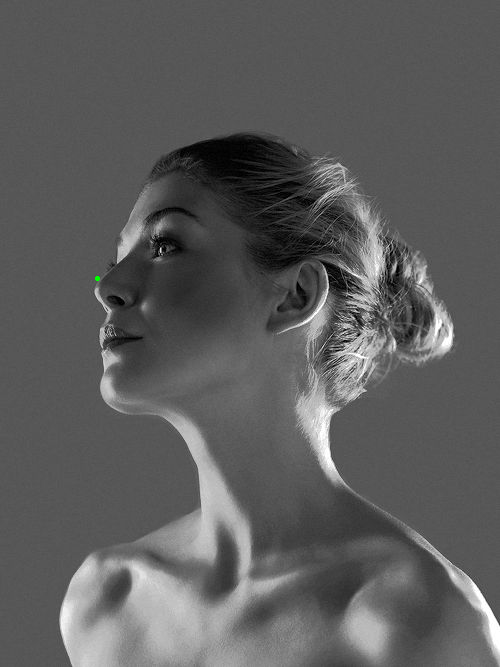

Predicted Pose Angles:
Pitch: [0.42919972]
Yaw: [1.05963659]
Roll: [0.382331]


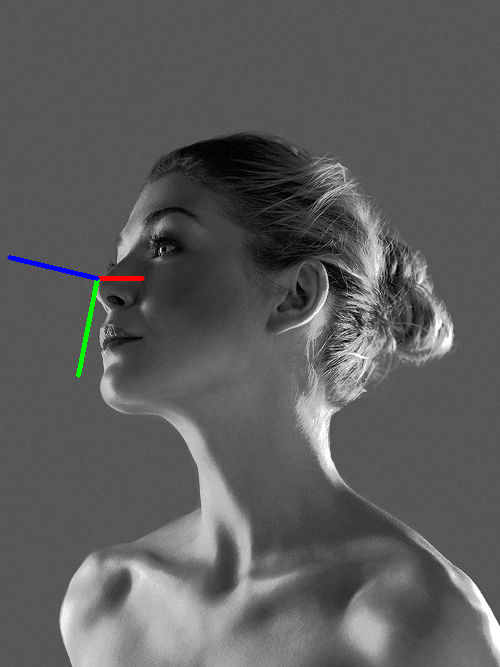

In [33]:
import cv2
import numpy as np
import mediapipe
from google.colab.patches import cv2_imshow

faceModule = mediapipe.solutions.face_mesh


def extract_features(image):
    features = []
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None:
            nose_landmark = results.multi_face_landmarks[0].landmark[4]
            chin_landmark = results.multi_face_landmarks[0].landmark[152]
            Distance = np.sqrt((nose_landmark.x - chin_landmark.x) ** 2 + (nose_landmark.y - chin_landmark.y) ** 2)
            # looping over the faces in the image
            for face in results.multi_face_landmarks:
                shape = image.shape
                nose_x = int(face.landmark[4].x * shape[1])
                nose_y = int(face.landmark[4].y * shape[0])
                for landmark in face.landmark:
                    x = (landmark.x - nose_landmark.x) / Distance
                    y = (landmark.y - nose_landmark.y) / Distance
                    features.extend([x, y])
                    cv2.circle(image, (nose_x, nose_y), radius=1, color=(0, 255, 0), thickness=2)
            cv2_imshow(image)
            return np.array(features).reshape(1, -1),nose_x,nose_y
        else:
            return None


def predict_pose_angles(image, svr_model_936, svr_model_937, svr_model_938):
    features,nose_x,nose_y = extract_features(image)
    if features is not None and features.shape[1] > 0:  # Check if features array has at least one column
        Pitch = svr_model_Pitch.predict(features)
        Yaw = svr_model_Yaw.predict(features)
        Roll = svr_model_Roll.predict(features)
        return Pitch, Yaw, Roll,nose_x,nose_y
    else:
        return None, None, None


# Example usage:
image = cv2.imread("/content/test2.jpg")  # Load your image here
Pitch, Yaw, Roll,nose_x,nose_y = predict_pose_angles(image, svr_model_Pitch, svr_model_Yaw, svr_model_Roll)
print("Predicted Pose Angles:")
print("Pitch:", Pitch)
print("Yaw:", Yaw)
print("Roll:", Roll)
cv2_imshow(draw_axis(image, Pitch, Yaw, Roll, nose_x, nose_y))


## Trying Model on Video

In [67]:
# Load the face detection module
import mediapipe
faceModule = mediapipe.solutions.face_mesh

# Load the video
video_path = r"/content/Presidential Debate - DT_ Bc you'd be in jail! - Hillary Clinton vs. Donald Trump.mp4"
cap = cv2.VideoCapture(video_path)

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Initialize video writer to write output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output1_video.mp4', fourcc, fps, (width, height))

# Loop through each frame in the video
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to RGB (as required by MediaPipe)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Perform face detection and landmark estimation on the frame
    with faceModule.FaceMesh(static_image_mode=False) as faces:
        results = faces.process(frame_rgb)
        if results.multi_face_landmarks:
            # Initialize variables to store face-specific data
            face_nodes_list = []
            nose_landmark_list = []

            for face in results.multi_face_landmarks:
                shape = frame.shape
                nose_x = int(face.landmark[4].x * shape[1])
                nose_y = int(face.landmark[4].y * shape[0])
                face_nodes = []
                nose_landmark = results.multi_face_landmarks[0].landmark[4]
                chin_landmark = results.multi_face_landmarks[0].landmark[152]
                Distance = np.sqrt((nose_landmark.x - chin_landmark.x) ** 2 + (nose_landmark.y - chin_landmark.y) ** 2)
                for index, landmark in enumerate(face.landmark):

                    x = (landmark.x - nose_landmark.x) / Distance
                    y = (landmark.y - nose_landmark.y) / Distance

                    face_nodes.extend([x, y])

                face_nodes = np.array(face_nodes).reshape(1, -1)
                face_nodes_list.append(face_nodes)
                nose_landmark_list.append(nose_landmark)

            # Predict head pose using SVR models for all faces in the frame
            pitch = svr_model_Pitch .predict(np.vstack(face_nodes_list))
            yaw = svr_model_Yaw.predict(np.vstack(face_nodes_list))
            roll = svr_model_Roll.predict(np.vstack(face_nodes_list))

            frame_with_axis = frame.copy()
            # Draw axis on the frame for all faces
            for i in range(len(face_nodes_list)):
                frame_with_axis = draw_axis(frame_with_axis, pitch[i], yaw[i], roll[i],nose_x,nose_y)

                # Write the frame with axis to the output video
            out.write(frame_with_axis)

cap.release()
out.release()
cv2.destroyAllWindows


<function destroyAllWindows>